In [75]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)


Common init:         -------------------------- 2023-07-07 15:49:32
dtype:               torch.float32
device:              cpu
contextSize:         3


In [77]:
logSection("Prepare dataset")

filePath = "names.txt"
log("filePath", filePath)

trRatio = 0.8
log("trRatio", trRatio)

devRatio = 0.9
log("devRatio", devRatio)

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)

words = readFileSplitByLine(filePath)
random.seed(wordShufflingSeed)
random.shuffle(words)
log("first few words", words[:5])

lenWords = len(words);
log("lenWords", lenWords)

allPossibleChars = sorted(list(set("".join(words))))
log("allPossibleChars", allPossibleChars)

stoi = sToI(allPossibleChars)
log("stoi", stoi)

itos = iToS(stoi)
log("itos", itos)

vocabularyLength = len(itos)
log("vocabularyLength", vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
log("data set training", lenTrain, trX.shape, trY.shape, trWords[:3])

endVal = int(devRatio * lenWords)
valWords = words[lenTrain:endVal];
valX, valY = buildDataSet(valWords, contextSize, stoi, itos, dvc)
log("data set validation", endVal - lenTrain, valX.shape, valY.shape, valWords[:3])

lenTest = lenWords - endVal
tstWords = words[endVal:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
log("data set test", lenTest, tstX.shape, tstY.shape, tstWords[:3])

Prepare dataset:     -------------------------- 2023-07-07 15:49:32
filePath:            names.txt
trRatio:             0.8
devRatio:            0.9
wordShufflingSeed:   42
first few words:     ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:            32033
allPossibleChars:    ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:                {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabularyLength:    27
data set training:   25626 torch.Size([18

Build network:       -------------------------- 2023-07-07 15:49:33
embeddingDims:       10
hiddenLayerSize:     200
learningSeed:        2147483647
W1ratio:             0.3042903097250923
b1ratio:             0.01
W2ratio:             0.1
b2ratio:             0
parametersCount:     12097
random probability:  3.2958


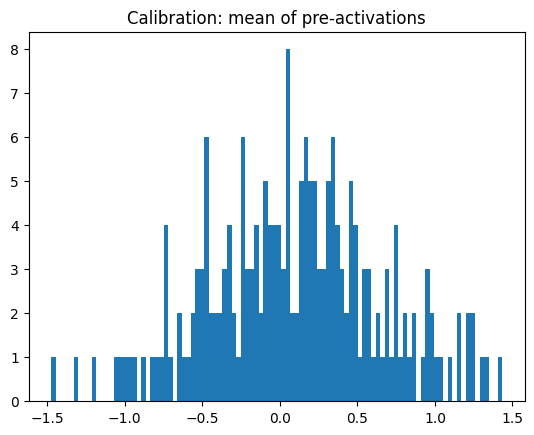

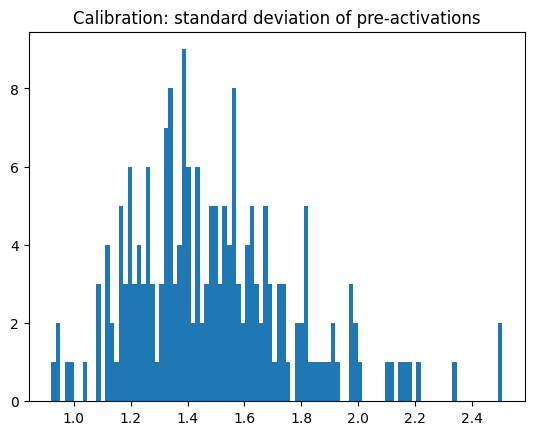

In [78]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

log("random probability", f"{-torch.tensor(1 / vocabularyLength).log().item():.4f}")

cal = calibrateBatchNorm(np, trX)

plt.figure()
plt.hist(cal.mean.tolist(), 100)
plt.title("Calibration: mean of pre-activations")

plt.figure()
plt.hist(cal.std.tolist(), 100)
plt.title("Calibration: standard deviation of pre-activations")

@torch.no_grad()
def trLoss(): return getLoss(np, cal, np.C[trX], trY)

@torch.no_grad()
def valLoss(): return getLoss(np, cal, np.C[valX], valY)

@torch.no_grad()
def tstLoss(): return getLoss(np, cal, np.C[tstX], tstY)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Learning:            -------------------------- 2023-07-07 15:49:34
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        200000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    200000
  0,      0 losses:     0.0000       3.6903     3.6829     3.6889
  1,   5708 losses:     2.1427       2.3016     2.3105     2.3131
  2,  11416 losses:     2.2444       2.2294     2.2451     2.2426
  3,  17124 losses:     2.4571       2.2184     2.2375     2.2359
  4,  22832 losses:     2.0413       2.1939     2.2152     2.2168
  5,  28540 losses:     1.7225       2.1949     2.2195     2.2189
  6,  34248 losses:     2.5549       2.1705     2.1994     2.1957
  7,  39956 losses:     1.8364       2.1633     2.2040     2.1895
  8,  45664 losses:     1.7638       2.1585     2.1956     2.1907
  9,  51372 losses:     2.0006       2.1535     2.1873     2.1895
 10,  57080 losses:     2.3452       2.1469     2.1862     2.1854
 11,  62788 losses:   

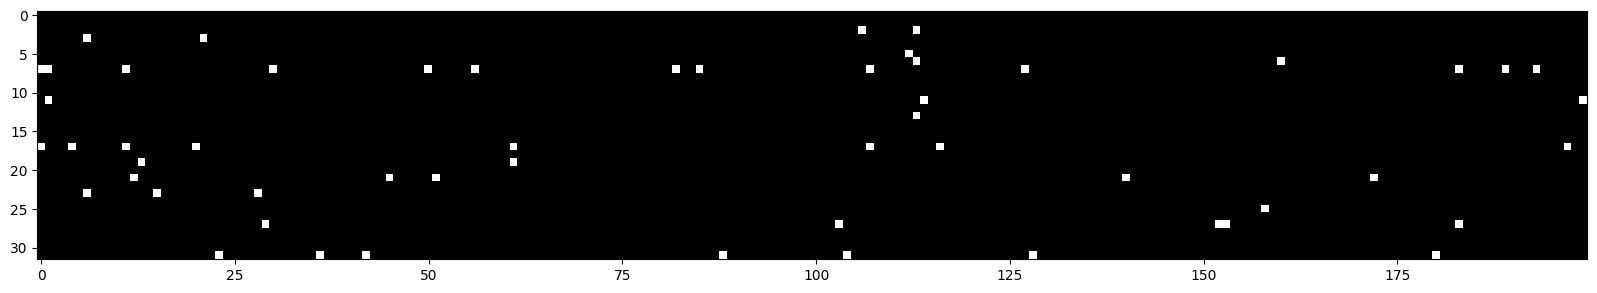

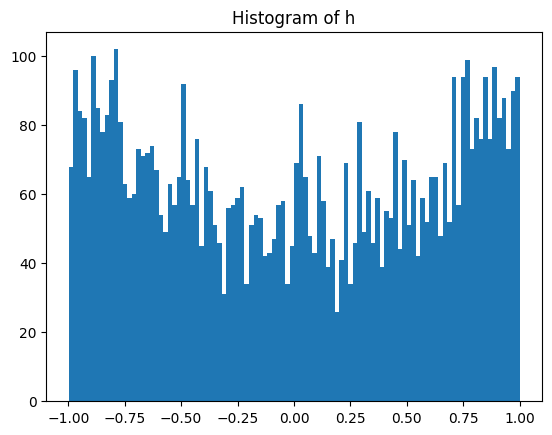

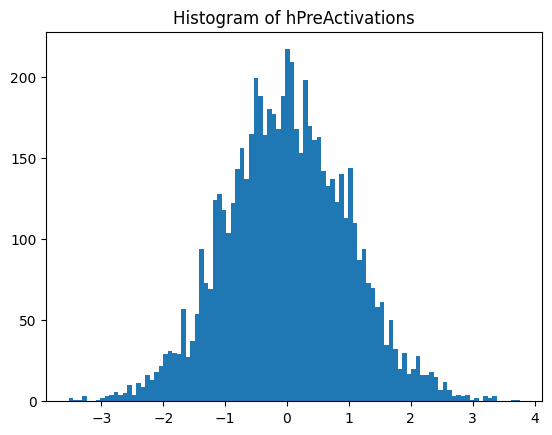

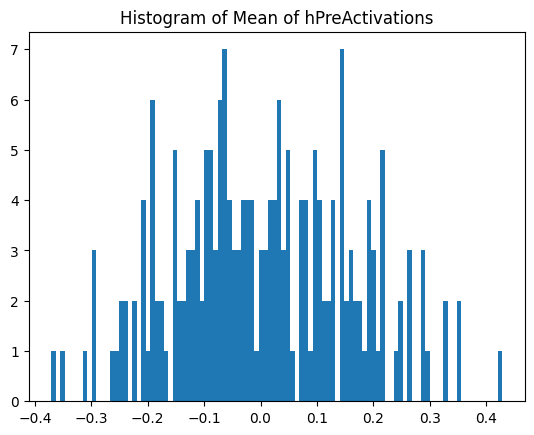

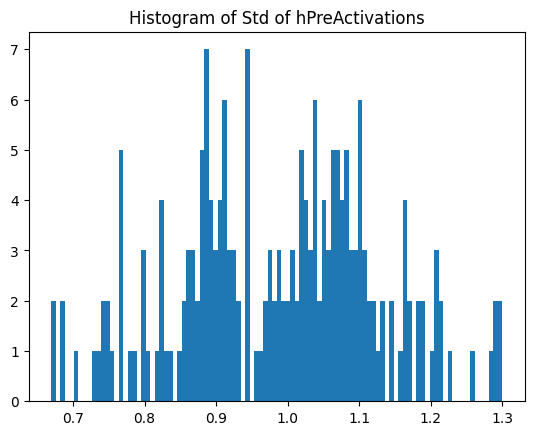

In [79]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration",maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
up = UpdateNetResult()

i = 0
for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, cal, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20, 10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
            
            plt.figure()
            plt.hist(fr.h.view(-1).tolist(), 100)
            plt.title('Histogram of h')

            plt.figure()
            plt.hist(fr.hPreActivations.view(-1).tolist(), 100)
            plt.title('Histogram of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.mean(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Mean of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.std(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Std of hPreActivations')

        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

In [80]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-07 15:52:25
samplingSeed:        2147483657
maxSampleLength:     50


In [105]:
samples = sampleMany(np, cal, gSampling, contextSize, itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

aery.                 255: 38 4 101 19 123 
kan.                  201: 25 114 11 35 
hil.                   79: 8 16 96 75 
sadelu.               104: 18 81 14 81 104 2 45 
aquav.                125: 38 1 152 114 29 2 
breonsen.              93: 11 132 60 8 127 7 57 60 204 
jamie.                216: 21 142 28 87 19 106 
roslandriggh.          76: 14 64 78 5 30 98 45 91 60 6 52 20 19 
amarquelme.           286: 38 25 88 139 4 237 118 64 4 79 63 
kimbanor.             130: 25 25 39 60 17 49 4 54 63 
joio.                  90: 21 46 4 5 137 
ahalorbenisha.        166: 38 6 38 11 18 53 0 125 82 20 29 89 150 59 
bridgeliya.           104: 11 132 73 13 45 121 41 82 12 247 85 
esticie.               90: 13 16 84 68 8 35 45 141 
livikchela.            65: 13 48 19 118 9 1 48 66 64 22 103 
surcine.               89: 18 18 34 9 94 23 5 216 
kimrosapportayanalysabella. 129: 25 25 39 3 19 56 59 2 32 7 146 66 22 7 33 61 60 15 35 29 26 44 161 177 179 80 169 
keer.                 190: 25 52 14 15 1

In [98]:
def printProb(txt: str):
    ps = calcProb(np, cal, txt, contextSize, stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    1      : 0 
m.                   6      : 21 0 
mi.                  37     : 21 41 0 
mic.                 127    : 21 41 38 10 
mich.                213    : 21 41 38 143 40 
micha.               178    : 21 41 38 143 96 11 
michal.              150    : 21 41 38 143 96 7 31 
michael.             211    : 21 41 38 143 96 11 219 67 
michaela.            207    : 21 41 38 143 96 11 219 41 103 
michaella.           205    : 21 41 38 143 96 11 219 21 80 169 
michel.              208    : 21 41 38 143 62 64 48 
michalx.             44     : 21 41 38 143 96 7 0 19 
michalxx.            37     : 21 41 38 143 96 7 0 3 18 
michalxxx.           28     : 21 41 38 143 96 7 0 3 1 24 
martin.              194    : 21 155 80 6 45 60 138 
andrej.              182    : 38 39 31 91 86 1 20 
andrey.              374    : 38 39 31 91 86 49 75 
joey.                155    : 21 46 13 15 193 
james.               196    : 21 142 28 63 17 89 
xin.                 18     : 1 52 128 79 
m

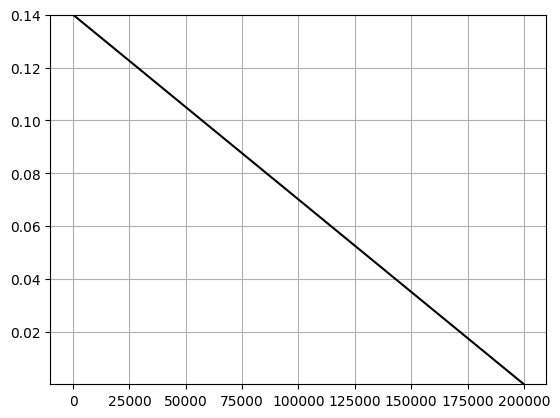

Actual min max LR 0.14 0.0001006994999999955


In [83]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

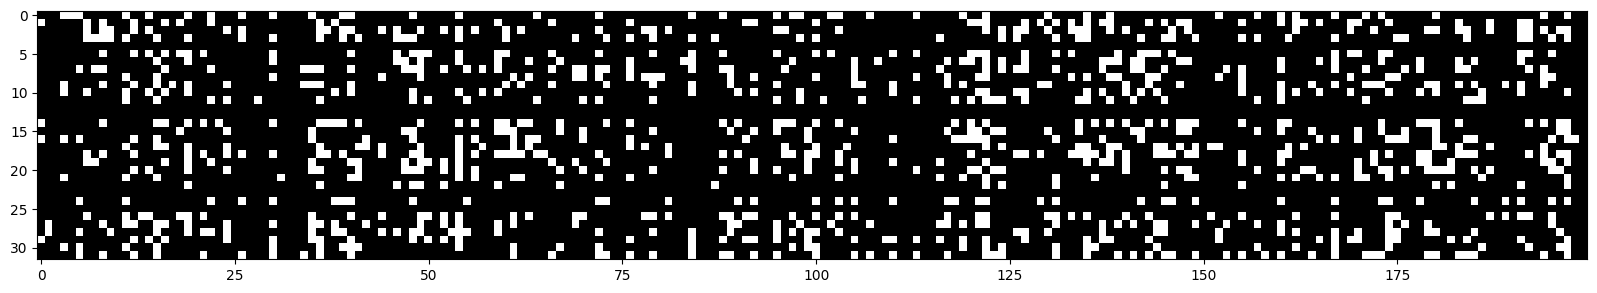

In [84]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

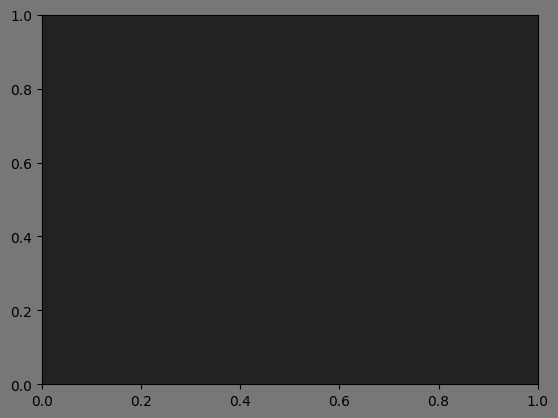

In [85]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

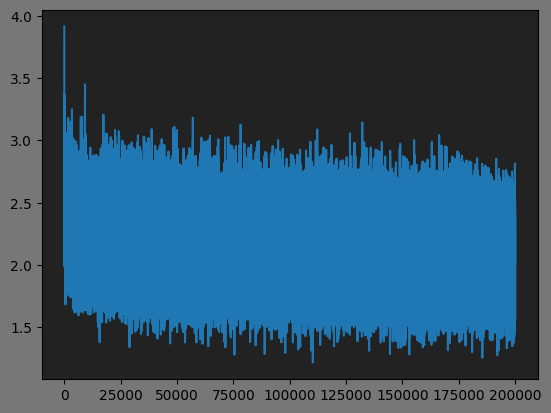

In [86]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

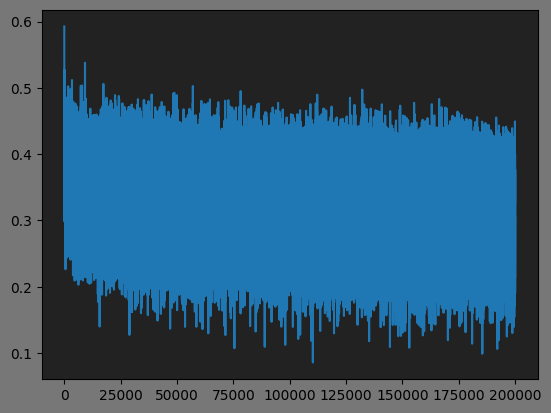

In [87]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

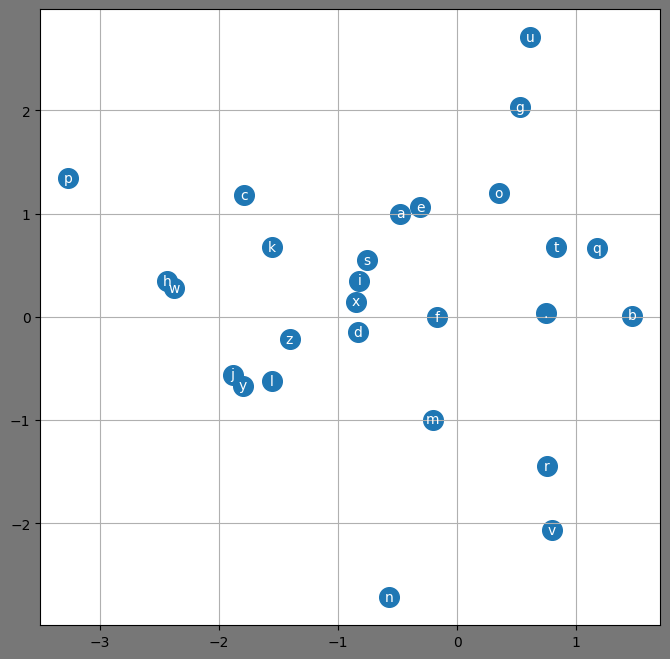

In [88]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

In [89]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 0.7440,  0.0333,  0.0682, -0.1331,  0.4711, -0.0637, -0.5545,  0.0260,
          -0.1372,  0.2372],
         [-0.4755,  1.0005, -0.0746, -0.3378,  0.7797,  1.9584,  0.5871, -0.8732,
           0.4232, -1.3323],
         [ 1.4709,  0.0123, -2.0352,  1.0638, -0.7457,  2.4124,  3.3953, -0.3055,
          -0.9357,  1.5070],
         [-1.7874,  1.1775,  0.4616,  1.4731, -1.3005, -0.6847, -2.0932,  2.0302,
          -0.9730,  1.2882],
         [-0.8317, -0.1464, -0.8265,  0.9199, -1.4446,  1.2903, -0.2532,  0.9564,
           0.1974, -0.9223]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 0.7440,  0.0333,  0.0682, -0.1331,  0.4711, -0.0637, -0.5545,
            0.0260, -0.1372,  0.2372],
          [ 0.7440,  0.0333,  0.0682, -0.1331,  0.4711, -0.0637, -0.5545,
            0.0260, -0.1372,  0.23

In [90]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
